# Testing different implementations of SRT

## Packages

In [2]:
%pylab inline
from collections import Counter, defaultdict
from scipy.stats import bernoulli
from scipy.stats import binom
import numpy as np

import multiprocessing

import torch
import torch.multiprocessing as mp

Populating the interactive namespace from numpy and matplotlib


##SRTv1 and SRTv2

### Simulation

#### SRT v1

In [3]:
#Estimation of SRT with correction

def SRT_v1(X, B, t0, t1, ps, tau):
    n = len(X)
    elements = []
    for el in range(1, B+1):
        elements.append(el)

    #Calculating true count
    cx = Counter(X)

    #Calculating true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #Randomization
    X_rand = []
    for x in X:
        ex = [0] * (B+1)
        ex[x] = 1
        for i in range(1, len(ex)):
            if ex[i] == 1:
                ex[i] = bernoulli.rvs(t1)
            else:
                ex[i] = bernoulli.rvs(t0)
        for i in range(len(ex)):
            if ex[i] == 1:
                X_rand.append(i)

    #Sampling (the implementation is different)
    sample = []
    for a in X_rand:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    #Thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0
        # correction
        if calg[k] > 0:
            calg[k] = int ((calg[k] - n * ps * t0) / (ps * (t1-t0)) )

    #Calculating estimated relative frequency (with the total size = total nonzer counts)
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#### SRTv2

In [4]:
import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def SRT_v2(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), ps, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * ps * t0) / (ps * (t1 - t0)))
        if calg[k] < tau:
            calg[k] = 0

    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

### Parameter tuning (Randomization mechanism)

In [5]:
def OUE(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = 1/2
    t0 = 1/(np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = ( (1 + alpha) * (1 - q**2) * n * p * t0 / eta - n * t0 ) / (t1 - t0)
    return t1, t0, float(p), tau

In [6]:
def DE(eps, delta, n, eps_0, B, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0) / (np.exp(eps_0) + B - 1)
    t0 = 1 / (np.exp(eps_0) + B - 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

In [7]:
def SYM(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0 / 2) / (np.exp(eps_0 / 2) + 1)
    t0 = 1 / (np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )


    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

## ST

###Simulation

In [8]:
#Estimation of ST with correction

def ST_sim(X, B, ps, tau):
    n = len(X)

    #counting true frequency
    cx = Counter(X)

    #obtaining true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #sampling
    sample = []
    for a in X:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    calg[k] = int(calg[k] / ps)  # correction
    #tau_corrected = tau / ps
    #thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0

    #obtaining estimated relative frequency
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#cx = true count
#phix = true relative frequency
#calg = estimated count after ST
#phialg = estimated relative frequency

### Parameter Tuning

In [9]:
def st_param(eps, delta, alpha = 0.2):
    if eps > 1:
      print("Warning of ST: eps is not allowed")
    ps = alpha * (1 - np.exp(-eps))
    Calp = np.log(1/alpha) - 1/(1+alpha)
    if Calp < 0:
      print("Warning of ST: C_alpha < 0")
    tau = 1 / Calp * np.log(1 / delta)
    return ps, tau / ps

## Exp. 1 $B = 2^{4}$.

### Implementation

In [10]:
#Comparing top k elements

Eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#Eps = [ 1 ]
Trials = 20

k = 5

delta = 1e-6
B = 2**4
#B = 2**6
#B= 2**8
n = 10**5

#storing data
Dataset = []

#define max errors
Err0_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err2_avg = []

#Checking GPU
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("GPU is unavailable")

for epsilon in Eps:

  p_st, tau_st = st_param(epsilon, delta, alpha = 1/6)
  print( f"ST parameters: p = {p_st}, tau = {tau_st}" )

  #Tuning SRT parameters
  eps_0 = 10
  optional_p = 0.5
  t1, t0, p_srt, tau_srt = OUE(epsilon, delta, n, eps_0)
  print( f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}" )
  if p_srt == 1.0:
    print( f"Warning: tighter epsilon guarantee of SRT at epsilon = {epsilon}" )

  #define max errors
  Err0_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):

      #Creating random binomial samples
      X = binom.rvs(n = B, p=0.4, size=n)

      #Implementing ST
      cx0, phix0, calg0, phialg0 = SRT_v2( X, B, 0, 1, p_st, tau_st, device )

      #Running SRT
      cx2, phix2, calg2, phialg2 = SRT_v2( X, B, t0, t1, p_srt, tau_srt, device )

      if trials == 0:
        for i in range(B):
          if cx0[i] != cx2[i]:
            print("Error: real data does not match.")
      
      #storing data
      Dataset.append( [cx0, calg0, calg2] )

      #Measuring errors
      err0 = []
      err2 = []
      k_frequent = cx0.most_common(k)

      for i in range(len(k_frequent)):
          entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err2_avg_temp.append(mean(err2))

      print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

  print("checkpoint: epsilon =  ", epsilon)

GPU is available
ST parameters: p = 0.01586043032734008, tau = 932.0055029135224
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.19265862279962112, tau = 2734.514927643805
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
checkpoint: trials =   4
checkpoint: trials =   5
checkpoint: trials =   6
checkpoint: trials =   7
checkpoint: trials =   8
checkpoint: trials =   9
checkpoint: trials =   10
checkpoint: trials =   11
checkpoint: trials =   12
checkpoint: trials =   13
checkpoint: trials =   14
checkpoint: trials =   15
checkpoint: trials =   16
checkpoint: trials =   17
checkpoint: trials =   18
checkpoint: trials =   19
checkpoint: epsilon =   0.1
ST parameters: p = 0.030211541153669697, tau = 489.283491645442
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.3665556823115922, tau = 3476.172430736101
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
chec

### Graphics

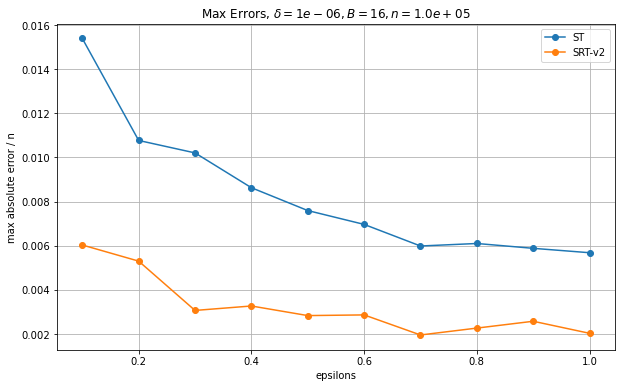

In [11]:
#Plotting maximum errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_max, '-o', label = "SRT-v2")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Max Errors, $\delta = {delta}, B = {B}, n = {n:.1e}$")
plt.xlabel('epsilons')
plt.ylabel('max absolute error / n')
plt.grid(True)
plt.legend()
plt.show()

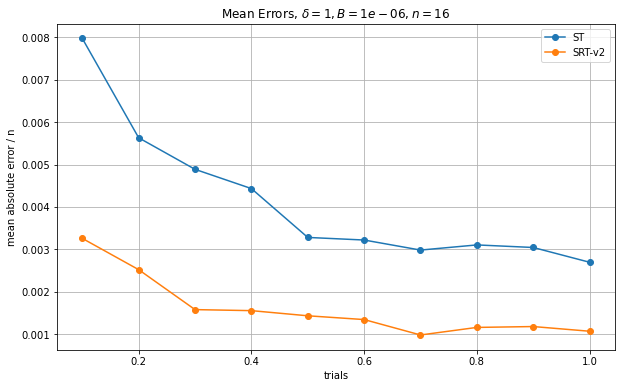

In [12]:
#Plotting average errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_avg, '-o', label = "SRT-v2")

plt.title("Mean Errors, $\delta = {}, B = {}, n = {}$".format(epsilon, delta, B, n))
plt.xlabel('trials')
plt.ylabel('mean absolute error / n')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
print("Err0_max: ", Err0_max)
print("Err2_max: ", Err2_max)
print("Err0_avg: ", Err0_avg)
print("Err2_avg: ", Err2_avg)
print("Dataset: ", Dataset)

Err0_max:  [0.015395500000000001, 0.010772, 0.010207500000000001, 0.008629500000000002, 0.007594000000000002, 0.0069665000000000005, 0.0059875, 0.0061010000000000005, 0.005882, 0.0056825]
Err2_max:  [0.0060325, 0.0053015, 0.0030664999999999998, 0.003268000000000001, 0.0028329999999999996, 0.0028635000000000006, 0.001954, 0.0022660000000000002, 0.0025755000000000005, 0.002029]
Err0_avg:  [0.0079726, 0.0056301, 0.0048863, 0.004432300000000001, 0.0032805, 0.0032191999999999998, 0.0029823000000000002, 0.0031037, 0.0030432999999999997, 0.0026949]
Err2_avg:  [0.0032576000000000003, 0.0025201999999999994, 0.0015781, 0.0015539, 0.0014325000000000002, 0.0013433, 0.0009800000000000002, 0.0011583, 0.0011787, 0.0010681000000000002]
Dataset:  [[Counter({6: 19945, 7: 18832, 5: 16318, 8: 14041, 4: 10038, 9: 8502, 3: 4687, 10: 3867, 2: 1541, 11: 1410, 12: 402, 1: 305, 13: 73, 0: 28, 14: 9, 15: 2}), [0, 0, 1702, 3909, 11033, 17338, 19671, 19797, 14816, 8385, 4287, 1828, 0, 0, 0, 0, 0], [0, 0, 0, 4693, 

#### graphing binomials

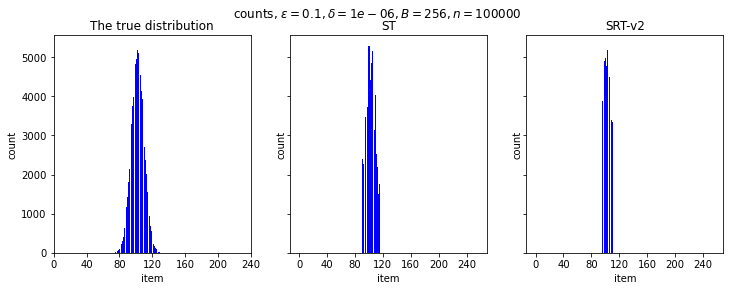

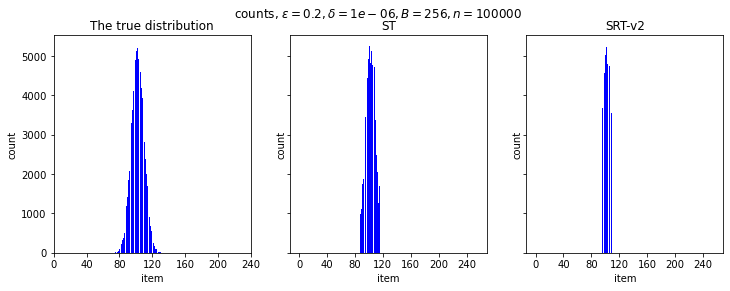

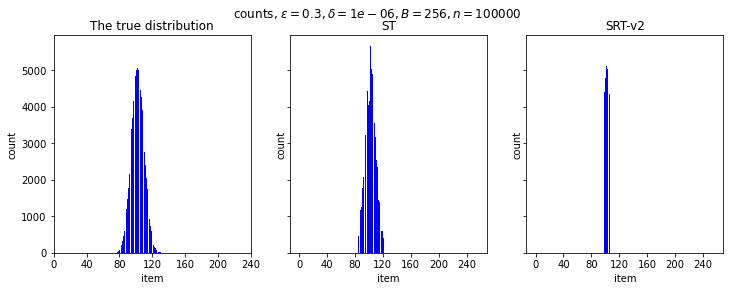

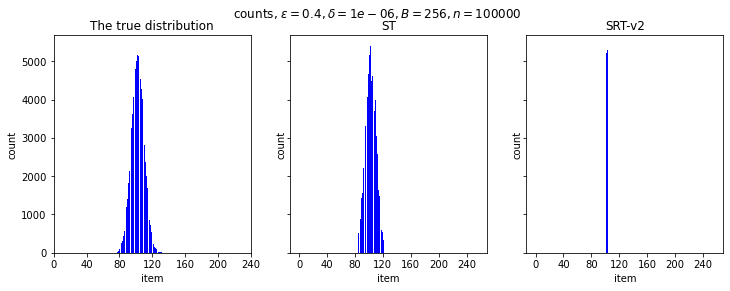

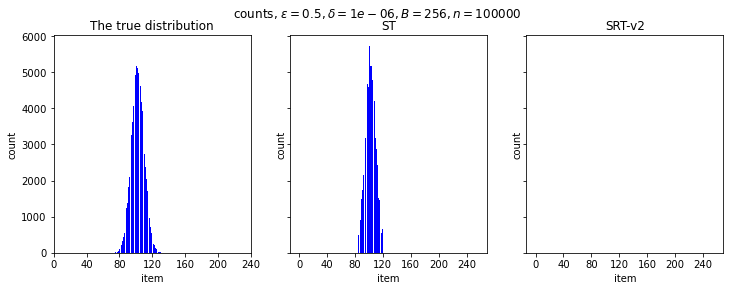

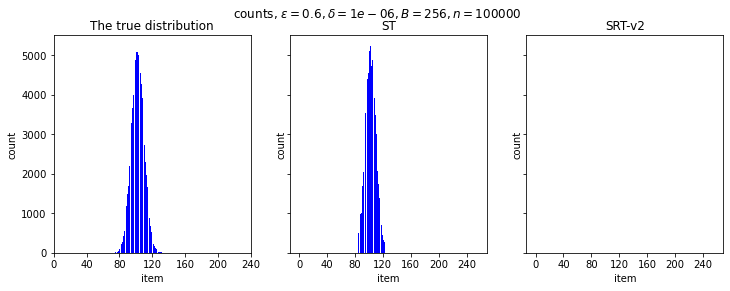

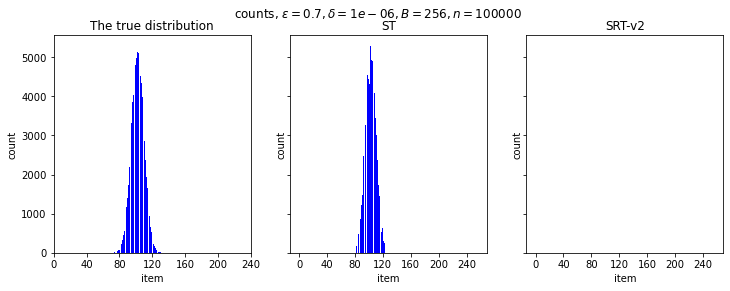

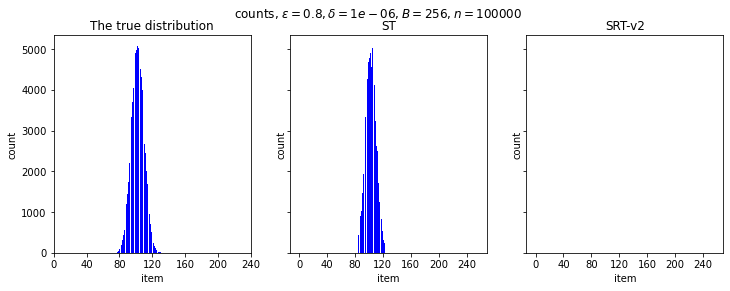

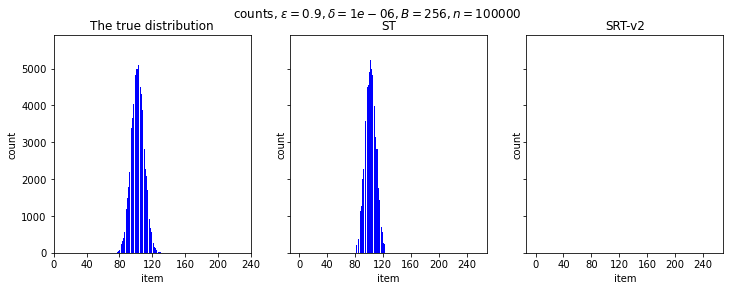

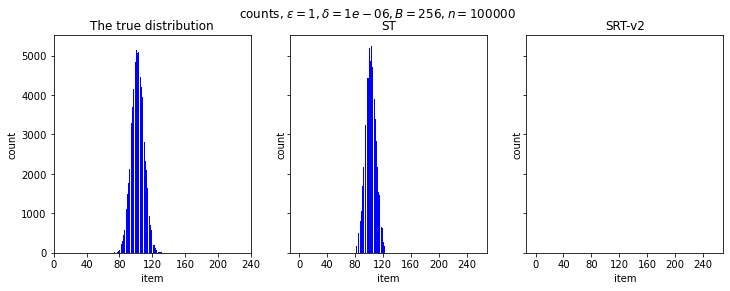

In [85]:
#Checking dimension
for i in range(len(Dataset)):
    cx0 = Dataset[i][0]
    calg0 = Dataset[i][1]
    calg2 = Dataset[i][2]

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
    f.suptitle(f"counts, $\epsilon = {Eps[i]}, \delta = {delta}, B = {B}, n = {n}$")
    stepsize = 40

    ax1.bar(cx0.keys(), cx0.values(),  color='b')
    ax1.set_title("The true distribution")
    ax1.set_xticks(range(0, B, stepsize))
    ax1.set_xlabel("item")
    ax1.set_ylabel("count")

    ax2.bar(range(len(calg0)), calg0,  color='b')
    ax2.set_title(r"ST")
    ax2.set_xticks(range(0, B, stepsize))
    ax2.set_xlabel("item")
    ax2.set_ylabel("count")

    ax3.bar( range(len(calg2)), calg2,  color='b')
    ax3.set_title(r"SRT-v2")
    ax3.set_xticks(range(0, B, stepsize))
    ax3.set_xlabel("item")
    ax3.set_ylabel("count")

## Exp 2. $B = 2^6$

In [14]:
#Comparing top k elements

Eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#Eps = [ 1 ]
Trials = 20

k = 5

delta = 1e-6
#B = 2**4
B = 2**6
#B= 2**8
n = 10**5

#storing data
Dataset = []

#define max errors
Err0_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err2_avg = []

#Checking GPU
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("GPU is unavailable")

for epsilon in Eps:

  p_st, tau_st = st_param(epsilon, delta, alpha = 1/6)
  print( f"ST parameters: p = {p_st}, tau = {tau_st}" )

  #Tuning SRT parameters
  eps_0 = 10
  optional_p = 0.5
  t1, t0, p_srt, tau_srt = OUE(epsilon, delta, n, eps_0)
  print( f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}" )
  if p_srt == 1.0:
    print( f"Warning: tighter epsilon guarantee of SRT at epsilon = {epsilon}" )

  #define max errors
  Err0_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):

      #Creating random binomial samples
      X = binom.rvs(n = B, p=0.4, size=n)

      #Implementing ST
      cx0, phix0, calg0, phialg0 = SRT_v2( X, B, 0, 1, p_st, tau_st, device )

      #Running SRT
      cx2, phix2, calg2, phialg2 = SRT_v2( X, B, t0, t1, p_srt, tau_srt, device )

      if trials == 0:
        for i in range(B):
          if cx0[i] != cx2[i]:
            print("Error: real data does not match.")
      
      #storing data
      Dataset.append( [cx0, calg0, calg2] )

      #Measuring errors
      err0 = []
      err2 = []
      k_frequent = cx0.most_common(k)

      for i in range(len(k_frequent)):
          entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err2_avg_temp.append(mean(err2))

      print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

  print("checkpoint: epsilon =  ", epsilon)

GPU is available
ST parameters: p = 0.01586043032734008, tau = 932.0055029135224
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.19265862279962112, tau = 2734.514927643805
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
checkpoint: trials =   4
checkpoint: trials =   5
checkpoint: trials =   6
checkpoint: trials =   7
checkpoint: trials =   8
checkpoint: trials =   9
checkpoint: trials =   10
checkpoint: trials =   11
checkpoint: trials =   12
checkpoint: trials =   13
checkpoint: trials =   14
checkpoint: trials =   15
checkpoint: trials =   16
checkpoint: trials =   17
checkpoint: trials =   18
checkpoint: trials =   19
checkpoint: epsilon =   0.1
ST parameters: p = 0.030211541153669697, tau = 489.283491645442
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.3665556823115922, tau = 3476.172430736101
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
chec

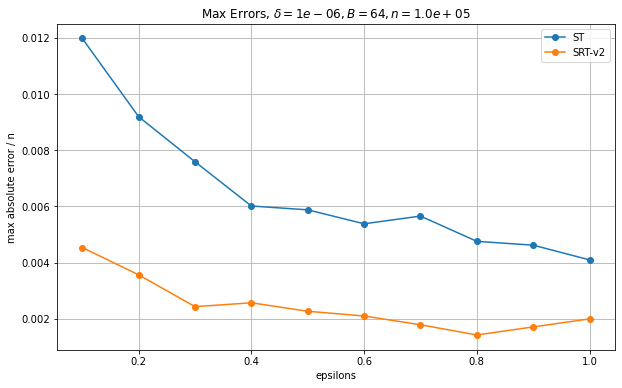

In [15]:
#Plotting maximum errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_max, '-o', label = "SRT-v2")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Max Errors, $\delta = {delta}, B = {B}, n = {n:.1e}$")
plt.xlabel('epsilons')
plt.ylabel('max absolute error / n')
plt.grid(True)
plt.legend()
plt.show()

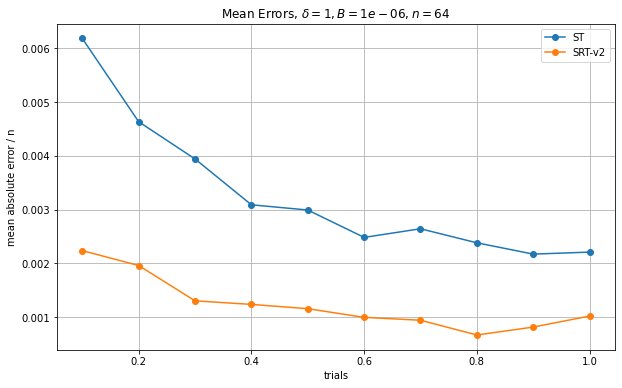

In [16]:
#Plotting average errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_avg, '-o', label = "SRT-v2")

plt.title("Mean Errors, $\delta = {}, B = {}, n = {}$".format(epsilon, delta, B, n))
plt.xlabel('trials')
plt.ylabel('mean absolute error / n')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
print("Err0_max: ", Err0_max)
print("Err2_max: ", Err2_max)
print("Err0_avg: ", Err0_avg)
print("Err2_avg: ", Err2_avg)
print("Dataset: ", Dataset)

Err0_max:  [0.011975999999999999, 0.009190000000000002, 0.007586999999999998, 0.006013, 0.005877499999999999, 0.00538, 0.0056549999999999994, 0.0047555, 0.0046194999999999995, 0.004096]
Err2_max:  [0.004533500000000001, 0.003562, 0.0024314999999999996, 0.0025685, 0.002267, 0.0020990000000000006, 0.0017865, 0.0014234999999999999, 0.0017104999999999998, 0.001996]
Err0_avg:  [0.0061833, 0.004635, 0.003942200000000001, 0.0030900999999999993, 0.0029928, 0.0024837, 0.0026441, 0.0023831, 0.0021728999999999997, 0.0022101000000000004]
Err2_avg:  [0.0022375, 0.0019611000000000003, 0.001304, 0.0012378, 0.0011581999999999999, 0.0009965000000000002, 0.0009431, 0.0006691, 0.0008160999999999999, 0.001021]
Dataset:  [[Counter({25: 10049, 26: 10030, 24: 9416, 27: 9329, 28: 8328, 23: 8271, 29: 7110, 22: 6793, 30: 5446, 21: 5098, 31: 3969, 20: 3745, 32: 2635, 19: 2484, 33: 1771, 18: 1502, 34: 1070, 17: 864, 35: 660, 16: 446, 36: 314, 15: 212, 37: 150, 14: 112, 38: 83, 13: 38, 39: 35, 12: 16, 40: 11, 41: 

## Exp 2. $B = 2^8$

In [18]:
#Comparing top k elements

Eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#Eps = [ 1 ]
Trials = 20

k = 5

delta = 1e-6
#B = 2**4
#B = 2**6
B= 2**8
n = 10**5

#storing data
Dataset = []

#define max errors
Err0_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err2_avg = []

#Checking GPU
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("GPU is unavailable")

for epsilon in Eps:

  p_st, tau_st = st_param(epsilon, delta, alpha = 1/6)
  print( f"ST parameters: p = {p_st}, tau = {tau_st}" )

  #Tuning SRT parameters
  eps_0 = 10
  optional_p = 0.5
  t1, t0, p_srt, tau_srt = OUE(epsilon, delta, n, eps_0)
  print( f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}" )
  if p_srt == 1.0:
    print( f"Warning: tighter epsilon guarantee of SRT at epsilon = {epsilon}" )

  #define max errors
  Err0_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):

      #Creating random binomial samples
      X = binom.rvs(n = B, p=0.4, size=n)

      #Implementing ST
      cx0, phix0, calg0, phialg0 = SRT_v2( X, B, 0, 1, p_st, tau_st, device )

      #Running SRT
      cx2, phix2, calg2, phialg2 = SRT_v2( X, B, t0, t1, p_srt, tau_srt, device )

      if trials == 0:
        for i in range(B):
          if cx0[i] != cx2[i]:
            print("Error: real data does not match.")
      
      #storing data
      Dataset.append( [cx0, calg0, calg2] )

      #Measuring errors
      err0 = []
      err2 = []
      k_frequent = cx0.most_common(k)

      for i in range(len(k_frequent)):
          entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err2_avg_temp.append(mean(err2))

      print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

  print("checkpoint: epsilon =  ", epsilon)

GPU is available
ST parameters: p = 0.01586043032734008, tau = 932.0055029135224
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.19265862279962112, tau = 2734.514927643805
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
checkpoint: trials =   4
checkpoint: trials =   5
checkpoint: trials =   6
checkpoint: trials =   7
checkpoint: trials =   8
checkpoint: trials =   9
checkpoint: trials =   10
checkpoint: trials =   11
checkpoint: trials =   12
checkpoint: trials =   13
checkpoint: trials =   14
checkpoint: trials =   15
checkpoint: trials =   16
checkpoint: trials =   17
checkpoint: trials =   18
checkpoint: trials =   19
checkpoint: epsilon =   0.1
ST parameters: p = 0.030211541153669697, tau = 489.283491645442
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.3665556823115922, tau = 3476.172430736101
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
chec

<ipython-input-4-a52fcd0b998b>:43: RuntimeWarning: invalid value encountered in long_scalars
  phialg = {k: calg[k] / total_app for k in range(B)}


checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
checkpoint: trials =   4
checkpoint: trials =   5
checkpoint: trials =   6
checkpoint: trials =   7
checkpoint: trials =   8
checkpoint: trials =   9
checkpoint: trials =   10
checkpoint: trials =   11
checkpoint: trials =   12
checkpoint: trials =   13
checkpoint: trials =   14
checkpoint: trials =   15
checkpoint: trials =   16
checkpoint: trials =   17
checkpoint: trials =   18
checkpoint: trials =   19
checkpoint: epsilon =   0.4
ST parameters: p = 0.06557822338122776, tau = 225.4103204004903
SRT parameters: t1 = 0.5, t0 = 0.0066928509242848554, p_srt = 0.7933800047603727, tau = 5893.481387474778
checkpoint: trials =   0
checkpoint: trials =   1
checkpoint: trials =   2
checkpoint: trials =   3
checkpoint: trials =   4
checkpoint: trials =   5
checkpoint: trials =   6
checkpoint: trials =   7
checkpoint: trials =   8
checkpoint: trials =   9
checkpoint: trials =   10
checkpoint: trials =   11
checkpoint: tri

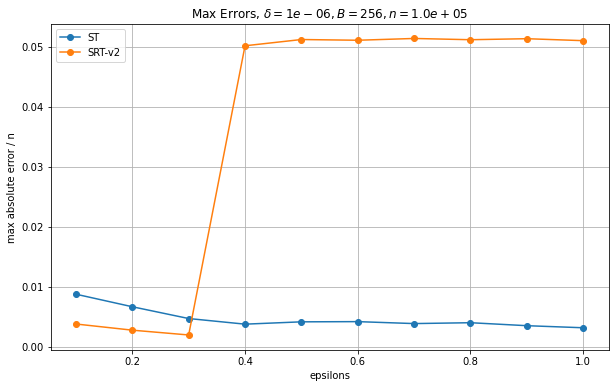

In [19]:
#Plotting maximum errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_max, '-o', label = "SRT-v2")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Max Errors, $\delta = {delta}, B = {B}, n = {n:.1e}$")
plt.xlabel('epsilons')
plt.ylabel('max absolute error / n')
plt.grid(True)
plt.legend()
plt.show()

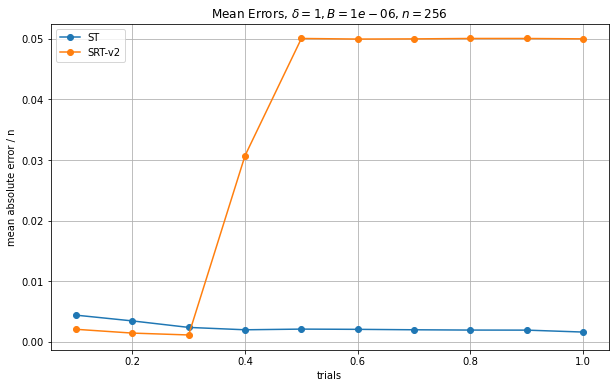

In [20]:
#Plotting average errors

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT-v1")
plt.plot(Eps, Err2_avg, '-o', label = "SRT-v2")

plt.title("Mean Errors, $\delta = {}, B = {}, n = {}$".format(epsilon, delta, B, n))
plt.xlabel('trials')
plt.ylabel('mean absolute error / n')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
print("Err0_max: ", Err0_max)
print("Err2_max: ", Err2_max)
print("Err0_avg: ", Err0_avg)
print("Err2_avg: ", Err2_avg)
print("Dataset: ", Dataset)

Err0_max:  [0.0087775, 0.006686500000000001, 0.004724000000000001, 0.0037864999999999995, 0.0041745, 0.0042075, 0.0038829999999999997, 0.004027500000000001, 0.0035309999999999994, 0.0031864999999999997]
Err2_max:  [0.003812499999999999, 0.0027859999999999994, 0.0019850000000000002, 0.050159999999999996, 0.05120199999999999, 0.0510815, 0.05137850000000001, 0.0511695, 0.051339, 0.051012]
Err0_avg:  [0.0043989, 0.0034487, 0.0023762, 0.0019831, 0.0020954, 0.0020562, 0.0019845, 0.0019366000000000001, 0.0019266, 0.0016069]
Err2_avg:  [0.0020638999999999996, 0.0014383000000000002, 0.001127, 0.0307111, 0.0500475, 0.049949400000000005, 0.04997839999999999, 0.0500467, 0.05004489999999999, 0.04998450000000001]
Dataset:  [[Counter({102: 5145, 103: 5125, 101: 5018, 104: 5001, 100: 4931, 99: 4767, 105: 4715, 106: 4470, 98: 4297, 107: 4289, 97: 4000, 108: 3962, 96: 3651, 109: 3577, 95: 3261, 110: 3157, 94: 2965, 111: 2728, 93: 2506, 112: 2394, 92: 2070, 113: 1991, 91: 1814, 114: 1737, 90: 1459, 115: 

## Trying parallelization

### SRT_parallel

In [ ]:
#Randomization and sampling

def process_element(x, ps):
    ex = [0] * (B + 1)
    ex[x] = 1

    # randomization
    for i in range(1, len(ex)):
        if ex[i] == 1:
            ex[i] = bernoulli.rvs(t1)
        else:
            ex[i] = bernoulli.rvs(t0)

    # sampling
    rv = bernoulli.rvs(ps)
    if rv:
        return [i for i, value in enumerate(ex) if value == 1]
    else:
        return []


#Estimation of SRT with correction

def SRT_parallel(X, B, t0, t1, ps, tau):
    n = len(X)
    elements = []
    for el in range(1, B+1):
        elements.append(el)

    #Calculating true count
    cx = Counter(X)

    #Calculating true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #Parallel computation
    partial_process_element = partial(process_element, ps = ps)
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()) as pool:
        results = pool.map(partial_process_element, X)

    # Flatten the list of results
    X_rand = [item for sublist in results for item in sublist]

    calg = Counter(X_rand)


    #Thresholding
    for k in calg.keys():
        # correction
        calg[k] = int ((calg[k] - n*ps*t0) / (ps * (t1-t0)) )
        if calg[k] < tau:
            calg[k] = 0

    #Calculating estimated relative frequency (with the total size = total nonzer counts)
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

###ST_parallel

In [ ]:
#Estimation of ST with correction
from functools import partial

#sampling function
def sampling(x, ps):
  sample = []
  rv = bernoulli.rvs(ps)
  if rv:
    sample.append(x)
  return sample


def ST_parallel(X, B, ps, tau, correction = True):
    n = len(X)

    #counting true frequency
    cx = Counter(X)

    #obtaining true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n


    #Parallel computation
    partial_sampling = partial( sampling, ps = ps )
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()) as pool:
        results = pool.map(partial_sampling, X)

    #Flatten the list of results
    X_rand = [item for sublist in results for item in sublist]

    calg = Counter(X_rand)

    #thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0

        if correction:
          calg[k] = int(calg[k] / ps)  # correction
        else:
          calg[k] = int(calg[k])  # correction

    #obtaining estimated relative frequency
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#cx = true count
#phix = true relative frequency
#calg = estimated count after ST
#phialg = estimated relative frequency